In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import bitfinex
from datetime import datetime
import time



# ML methods
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error


from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score
from keras.callbacks import LearningRateScheduler
from keras.metrics import RootMeanSquaredError
from sklearn.linear_model import LinearRegression

In [2]:
def fetch_data(start=1640991600000, stop=1651356000000, symbol='btcusd', interval='1D', step=31536000000):
    # Create api instance
    api_v2 = bitfinex.bitfinex_v2.api_v2()

    data = []
    names = ['time', 'open', 'close', 'high', 'low', 'volume']

    if stop > time.time() * 1000: # stop value can't be higher than datetime.now()
        stop = datetime.now()
        stop = time.mktime(stop.timetuple()) * 1000
    if stop - start > step: # if data requested > 365 days
        while start < stop:
            if start + step > stop: # if start + 365 days > stop => stop = now
                end = datetime.now()
                end = time.mktime(end.timetuple()) * 1000
            else:
                end = start + step
            #print(datetime.fromtimestamp(start / 1000), datetime.fromtimestamp(end / 1000))
            res = api_v2.candles(symbol=symbol, interval=interval, start=start, end=end)
            data.extend(res)
            start += step
            time.sleep(1)
    else:
        res = api_v2.candles(symbol=symbol, interval=interval, start=start, end=stop)
        data.extend(res)
    #print(data)

    # Modify data to send back a clean DataFrame
    df = pd.DataFrame(data, columns=names)
    df['time'] = pd.to_datetime(df['time'], unit='ms')
    df = df.sort_values(by='time')
    df.reset_index(inplace=True)
    df.drop('index', axis=1, inplace=True)
    df.rename(columns={'time':'date'}, inplace=True)
    return df

In [3]:
pair = 'btcusd'
interval = '1D'

t_start = datetime(2009, 1, 1, 0, 0)
t_start = time.mktime(t_start.timetuple()) * 1000

t_stop = datetime(2023, 1, 1, 0, 0)
t_stop = time.mktime(t_stop.timetuple()) * 1000

In [4]:
df = fetch_data(start=t_start, stop=t_stop, symbol=pair)
df

No keys, only access to public API functions


,date,open,close,high,low,volume
0,2013-03-31,92.500000,93.033000,93.74999,91.00000,3083.079791
1,2013-04-01,93.250000,103.999000,105.90000,92.49999,5224.401313
2,2013-04-02,104.000000,118.229354,118.38670,99.00000,8376.527478
3,2013-04-03,117.958261,134.700000,146.88000,101.51088,12996.245072
4,2013-04-04,134.716560,132.899000,143.00000,119.00000,6981.668305
...,...,...,...,...,...,...
3318,2022-05-08,35506.000000,34064.000000,35541.00000,33761.00000,6577.706035
3319,2022-05-09,34075.000000,30140.000000,34277.00000,30100.00000,21250.245615
3320,2022-05-10,30136.000000,31072.000000,32687.00000,29833.00000,14172.682208
3321,2022-05-11,31065.327593,29149.000000,32227.00000,27900.00000,28729.965053


In [10]:
close_data = df.filter(['close'])
dataset = close_data.values
training_data_len = int(np.ceil(len(dataset) * .90))

training_data_len

2991

In [11]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

In [14]:
train_data = scaled_data[0:int(training_data_len), :]

X_train = []
y_train = []

for i in range(60, len(train_data)):
    X_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    if i <= 61:
        print(X_train)
        print(y_train)
        print()
X_train, y_train = np.array(X_train), np.array(y_train)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

[array([3.98948234e-04, 5.61504112e-04, 7.72449552e-04, 1.01660424e-03,
       9.89906890e-04, 1.12926379e-03, 1.14038151e-03, 1.42579560e-03,
       1.79165750e-03, 2.47361839e-03, 1.42128922e-03, 5.02224433e-04,
       6.80107940e-04, 3.70294166e-04, 3.56523018e-04, 2.54699534e-04,
       2.17610823e-05, 3.99392943e-04, 6.69731402e-04, 7.83873318e-04,
       9.02462323e-04, 7.63387068e-04, 8.95050510e-04, 1.14681497e-03,
       1.31159439e-03, 1.12333434e-03, 1.05514567e-03, 9.24697761e-04,
       1.02520194e-03, 1.15446396e-03, 1.09339062e-03, 7.39402442e-04,
       6.00060362e-04, 4.73466600e-04, 6.87519752e-04, 7.47851908e-04,
       6.80107940e-04, 6.50460689e-04, 7.02343378e-04, 6.90024945e-04,
       7.67122622e-04, 7.33117225e-04, 7.14202278e-04, 7.68738397e-04,
       6.73452132e-04, 6.34895882e-04, 7.24578816e-04, 7.63416715e-04,
       7.76757978e-04, 7.72755599e-04, 7.70383819e-04, 7.54226067e-04,
       7.85503917e-04, 8.55471430e-04, 9.27662486e-04, 9.31664865e-04,
     

In [29]:
test_data = scaled_data[training_data_len - 60:, :]

X_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    X_test.append(test_data[i-60:i, 0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [30]:
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))
model.add(Dropout(0.2))

model.compile(optimizer='adam', loss='mean_squared_error')



In [34]:
hist = model.fit(X_train, y_train, batch_size=32, epochs=100, validation_data=(X_test, y_test))

Epoch 1/100
92/92 [==============================] - 7s 70ms/step - loss: 0.0092 - val_loss: 2099991424.0000
Epoch 2/100
92/92 [==============================] - 6s 66ms/step - loss: 0.0076 - val_loss: 2099990016.0000
Epoch 3/100
92/92 [==============================] - 6s 69ms/step - loss: 0.0069 - val_loss: 2099993984.0000
Epoch 4/100
92/92 [==============================] - 6s 70ms/step - loss: 0.0071 - val_loss: 2099993984.0000
Epoch 5/100
92/92 [==============================] - 6s 69ms/step - loss: 0.0079 - val_loss: 2099996160.0000
Epoch 6/100
92/92 [==============================] - 7s 71ms/step - loss: 0.0069 - val_loss: 2099996544.0000
Epoch 7/100
92/92 [==============================] - 6s 68ms/step - loss: 0.0067 - val_loss: 2099993728.0000
Epoch 8/100
92/92 [==============================] - 6s 68ms/step - loss: 0.0066 - val_loss: 2099991808.0000
Epoch 9/100
92/92 [==============================] - 7s 72ms/step - loss: 0.0070 - val_loss: 2099992960.0000
Epoch 10/100
92/92 

In [35]:
hist.history

{'loss': [0.009194068610668182,
  0.007556769531220198,
  0.0069190748035907745,
  0.007098945789039135,
  0.007939453236758709,
  0.0068514300510287285,
  0.006742070894688368,
  0.006584135815501213,
  0.007000912446528673,
  0.008638269267976284,
  0.006785673089325428,
  0.006440341472625732,
  0.005019760690629482,
  0.00807757955044508,
  0.006221936084330082,
  0.006359385792165995,
  0.006034195888787508,
  0.008083212189376354,
  0.006297986023128033,
  0.005814200732856989,
  0.00632908521220088,
  0.005704878363758326,
  0.006031987722963095,
  0.0068959021009504795,
  0.005145701114088297,
  0.007269326597452164,
  0.0076682912185788155,
  0.00678230868652463,
  0.009202643297612667,
  0.007037848234176636,
  0.007236582227051258,
  0.00815363135188818,
  0.008981560356914997,
  0.0069441222585737705,
  0.007042332086712122,
  0.008119871839880943,
  0.006379254162311554,
  0.007874646224081516,
  0.007661703508347273,
  0.006110705900937319,
  0.007968875579535961,
  0.007

In [36]:
history_dict = hist.history

loss = history_dict["loss"]
root_mean_squared_error = history_dict["root_mean_squared_error"]
val_loss = history_dict["val_loss"]
val_root_mean_squared_error = history_dict["val_root_mean_squared_error"]

epochs = range(1, len(loss) + 1)

KeyError: 'root_mean_squared_error'

NameError: name 'epochs' is not defined

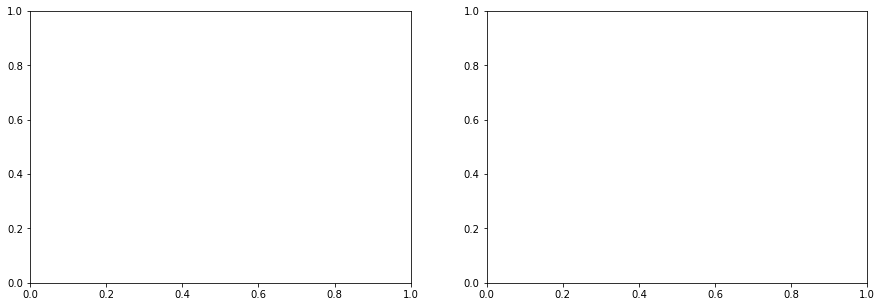

In [37]:
fig, (ax1, ax2) = plt.subplots(1, 2)

fig.set_figheight(5)
fig.set_figwidth(15)

ax1.plot(epochs, loss, label = 'Training Loss')
ax1.plot(epochs, val_loss, label = 'Validation Loss')
ax1.set(xlabel = "Epochs", ylabel = "Loss")
ax1.legend()

ax2.plot(epochs, root_mean_squared_error, label = "Training Root Mean Squared Error")
ax2.plot(epochs, val_root_mean_squared_error, label = "Validation Root Mean Squared Error")
ax2.set(xlabel = "Epochs", ylabel = "Loss")
ax2.legend()

plt.show()

In [38]:
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

In [39]:
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
rmse

9544.215331319167

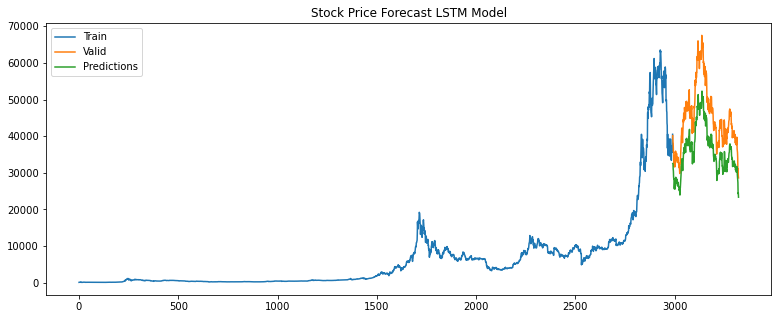

In [40]:
pd.options.mode.chained_assignment = None

train = close_data[:training_data_len]
valid = close_data[training_data_len:]
valid['predictions'] = predictions

plt.figure(figsize=(13,5))
plt.title('Stock Price Forecast LSTM Model')
plt.plot(train['close'])
plt.plot(valid[['close', 'predictions']])
plt.legend(['Train', 'Valid', 'Predictions'])
plt.show()